In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal
import neurokit2 as nk
import mne
from params import *
from bibliotheque import *
%matplotlib inline
# %matplotlib widget

## SAVE ?

In [3]:
save = True 
# save = False

## TOOLS

Preprocessing = 
* down sampling / 4 from 1000 to 250 Hz (enough to see until 125Hz), for less memory and faster computing
* bio = neurokit
* neuro = line noise removing + high pass 0.1 Hz

In [4]:
def preprocessing(sig, biosig, srate, participant):
    if biosig == 'ECG':
        clean = nk.ecg_clean(sig, sampling_rate=srate) 
        reverse = ecg_reverse[participant]
        if reverse == 1: # reverse if I have visually found than ecg have to be reversed to get peaks pointing up = better for peak finding by neurokit
            clean = -clean
    elif biosig == 'EDA':
        clean = nk.eda_clean(sig, sampling_rate=srate)
    elif biosig == 'PPG':
        clean = nk.ppg_clean(sig, sampling_rate=srate)
    elif biosig == 'EEG':
        clean = mne.filter.notch_filter(sig, srate, freqs=np.arange(50,101,50), verbose = False) # notch filter to remove line_noise
        clean = mne.filter.filter_data(clean, srate, l_freq = 0.1, h_freq = None, verbose = False) # remove slow drift with high pass 0.1         
    return clean

## GO

###  - CUT AND CLEAN DATA

In [5]:
df_times = pd.read_excel('../data/df_timestamps.xlsx', index_col=0).set_index(['participant','room'])
df_times

start  stop  duration  start date  stop date  \
participant room                                                             
P06PHERAX   Baseline              0   223       223       41084      41307   
            Take-off            542   718       176       41626      41802   
            Savannah            719   798        79       41803      41882   
            Canopy              808  1207       399       41892      42291   
            Bats               1217  1422       205       42301      42506   
...                             ...   ...       ...         ...        ...   
P18BLAMA    Bats               1067  1136        69       41848      41917   
            Underground        1189  1238        49       41970      42019   
            Grassland          1241  1602       361       42022      42383   
            Sea                1605  1835       230       42386      42616   
            End of the world   1853  2372       519       42634      43153   

                             start datetime stop datetime  
participant room                                           
P06PHERAX   Baseline               11:24:44      11:28:27  
            Take-off               11:33:46      11:36:42  
            Savannah               11:36:43      11:38:02  
            Canopy                 11:38:12      11:44:51  
            Bats                   11:45:01      11:48:26  
...                                     ...           ...  
P18BLAMA    Bats                   11:37:28      11:38:37  
            Underground            11:39:30      11:40:19  
            Grassland              11:40:22      11:46:23  
            Sea                    11:46:26      11:50:16  
            End of the world       11:50:34      11:59:13  

[252 rows x 7 columns]

In [6]:
da_cleaned = None

for participant in participants:
    print(participant)
    da_raw = xr.load_dataarray(f'../data_in_da/da_{participant}.nc') # load da of the participant
    data_duration = int(da_raw.coords['time'][-1].values) # get recording duration of the participant
    for room in rooms:
        # print(room)
        start = df_times.loc[(participant,room),'start'] # get starting room timestamps in secs after beginning of recording
        stop = start + sig_by_room_duration # stop = start + defined duration of computing
        if start > data_duration:
            print(participant , 'WARNING : Recording shorter than timestamping')
        else:
            for biosig in biosigs:
                if biosig == 'EEG':
                    sigR = da_raw.loc['EEGR',start:stop].values 
                    sigL = da_raw.loc['EEGL',start:stop].values
                    sig = (sigR+sigL) / 2 # mean left and right frontal eeg chans
                else:
                    sig = da_raw.loc[biosig,start:stop].values # sel and cut

                down_sig = down_sample(sig, factor=4) # down sample for less memory and faster computing
                down_srate = srate / 4 # new srate = 250 Hz

                down_clean = preprocessing(down_sig, biosig, srate=down_srate, participant=participant) # apply preproc according to biosig

                if da_cleaned is None:
                    da_cleaned = init_da({'participant':participants, 'room':rooms, 'biosig':biosigs, 'cleaning':['raw','clean'], 'time':time_vector(down_clean, srate=down_srate)}) # initialize a data array with good shape (5 dims)

                da_cleaned.loc[participant, room, biosig,'raw',:] = down_sig # keep sig before preproc
                da_cleaned.loc[participant, room, biosig,'clean',:] = down_clean # get sig after preproc

if save:
    da_cleaned.to_netcdf('../data_preprocessed/da_cleaned.nc') # save

P01PPILNI
P05PROZEM
P07GHOLE
P08AKKOR
P10LEVVA
P11KERSA
P12BOULI
P14BENLA
P15LEPMA
P16MAUAD
P17ETRPA
P19MONAL
P20POUAX
P21LIYAT
P22DALPI
P25PEIAN
P27OSTMA
P28JUDGU
P30BATDI


In [7]:
# get data from first 15 minutes and last 15 minutes to explore just an effect of the visit in sensory odyssey

da_visit_effect_cleaned = None

tips_duration = 15*60

recording_durations = {}
epochs = ['beginning','end']

for participant in participants_for_visit_effect:
    print(participant)
    da_raw = xr.load_dataarray(f'../data_in_da/da_{participant}.nc') # load da of the participant
    data_duration = int(da_raw.coords['time'][-1].values) # get recording duration of the participant
    recording_durations[participant] = data_duration
    
    if data_duration < tips_duration * 2:
        print(f'{participant} : epochs could be overlapping')
    
    for epoch in epochs:
        if epoch == 'beginning':
            start = 0 # first 15 minutes
            stop = tips_duration # last 15 minutes
        else:
            start = data_duration - tips_duration
            stop = data_duration

        for biosig in biosigs:
            if biosig == 'EEG':
                sigR = da_raw.loc['EEGR',start:stop].values 
                sigL = da_raw.loc['EEGL',start:stop].values
                sig = (sigR+sigL) / 2 # mean left and right frontal eeg chans
            else:
                sig = da_raw.loc[biosig,start:stop].values # sel and cut

            down_sig = down_sample(sig, factor=4) # down sample for less memory and faster computing
            down_srate = srate / 4 # new srate = 250 Hz

            down_clean = preprocessing(down_sig, biosig, srate=down_srate, participant=participant) # apply preproc according to biosig

            if da_visit_effect_cleaned is None:
                da_visit_effect_cleaned = init_da({'participant':participants_for_visit_effect, 'epoch':epochs, 'biosig':biosigs, 'cleaning':['raw','clean'], 'time':time_vector(down_clean, srate=down_srate)}) # initialize a data array with good shape (5 dims)

            da_visit_effect_cleaned.loc[participant, epoch, biosig,'raw',:] = down_sig # keep sig before preproc
            da_visit_effect_cleaned.loc[participant, epoch, biosig,'clean',:] = down_clean # get sig after preproc
if save:
    da_visit_effect_cleaned.to_netcdf('../data_preprocessed/da_visit_effect_cleaned.nc') # save

P01PPILNI
P03PBABCO
P05PROZEM
P07GHOLE
P08AKKOR
P09COUAM
P10LEVVA
P11KERSA
P12BOULI
P13MORMA
P14BENLA
P15LEPMA
P16MAUAD
P17ETRPA
P18BLAMA
P19MONAL
P20POUAX
P21LIYAT
P22DALPI
P23VIVBA
P24BELCL
P25PEIAN
P27OSTMA
P28JUDGU
P29FICMA
P30BATDI


## **GLOBAL VIEWER** :

In [8]:
save_quality_df = True

rows = []

for biosig in biosigs:    
    for participant in all_participants:
        rows.append([biosig, participant , 0])
quality_df_encoder = pd.DataFrame(rows, columns = ['biosig','participant','quality'])
if save_quality_df:
    quality_df_encoder.to_excel('../data_preprocessed/quality_encoding_3.xlsx')

In [9]:
da_cleaned

<xarray.DataArray (participant: 19, room: 9, biosig: 4, cleaning: 2, time: 22501)>
array([[[[[ 7.23758574e+02,  7.47533949e+02,  7.31159608e+02, ...,
            5.60590848e+02,  4.95836266e+02,  5.41206908e+02],
          [-1.70530257e-13,  2.07324372e+01,  6.67476693e+00, ...,
            1.75077331e+01, -4.43587850e+01, -5.68434189e-14]],

         [[ 5.13086713e+02,  5.14239300e+02,  5.12393733e+02, ...,
            5.32501656e+02,  5.31620439e+02,  5.24157627e+02],
          [-3.99481870e+00, -3.23349538e+00, -2.40230460e+00, ...,
            9.78090929e+00,  5.59578507e+00,  3.78464397e+00]],

         [[ 1.35434594e+02,  1.35405881e+02,  1.35642470e+02, ...,
            8.00720468e+01,  8.00731271e+01,  8.00728984e+01],
          [ 1.35440469e+02,  1.35449113e+02,  1.35457694e+02, ...,
            8.01139701e+01,  8.01139069e+01,  8.01138556e+01]],

         [[ 5.73360575e+01,  5.73371180e+01,  5.73339699e+01, ...,
            1.67885081e+01,  1.67062179e+01,  1.77650590e+01],
          [ 2.75827751e+01,  2.98107144e+01,  3.18742659e+01, ...,
           -1.12543724e+01, -1.29490419e+01, -1.47835627e+01]]],

...

        [[[ 5.42926016e+02,  6.60064396e+02,  6.59330190e+02, ...,
            5.35734717e+02,  5.16071151e+02,  5.36332673e+02],
          [ 2.13162821e-13,  1.13195147e+02,  1.13290008e+02, ...,
            2.52931199e+00, -1.76723928e+01,  9.94759830e-14]],

         [[ 5.12021931e+02,  5.13100286e+02,  5.13369195e+02, ...,
            5.09764861e+02,  5.10276184e+02,  5.12051941e+02],
          [ 4.02698987e+00,  4.61290739e+00,  5.14984887e+00, ...,
            9.92205147e+00,  1.17204462e+01,  1.35628190e+01]],

         [[ 1.14673535e+02,  1.15373660e+02,  1.15364801e+02, ...,
            1.19615897e+02,  1.19614083e+02,  1.19615421e+02],
          [ 1.14702888e+02,  1.14728799e+02,  1.14754523e+02, ...,
            1.19601624e+02,  1.19601607e+02,  1.19601594e+02]],

         [[ 2.57088017e+01,  2.57077225e+01,  2.56550803e+01, ...,
            2.66900401e+01,  2.66990748e+01,  2.66871430e+01],
          [-6.26258120e+00, -3.50812536e+00, -9.25309278e-01, ...,
            3.03212115e+00,  1.15212188e+00, -8.81779910e-01]]]]])
Coordinates:
  * participant  (participant) <U9 'P01PPILNI' 'P05PROZEM' ... 'P30BATDI'
  * room         (room) <U16 'Baseline' 'Take-off' ... 'Sea' 'End of the world'
  * biosig       (biosig) <U3 'EEG' 'ECG' 'EDA' 'PPG'
  * cleaning     (cleaning) <U5 'raw' 'clean'
  * time         (time) float64 0.0 0.004 0.008 0.012 ... 89.99 89.99 90.0 90.0

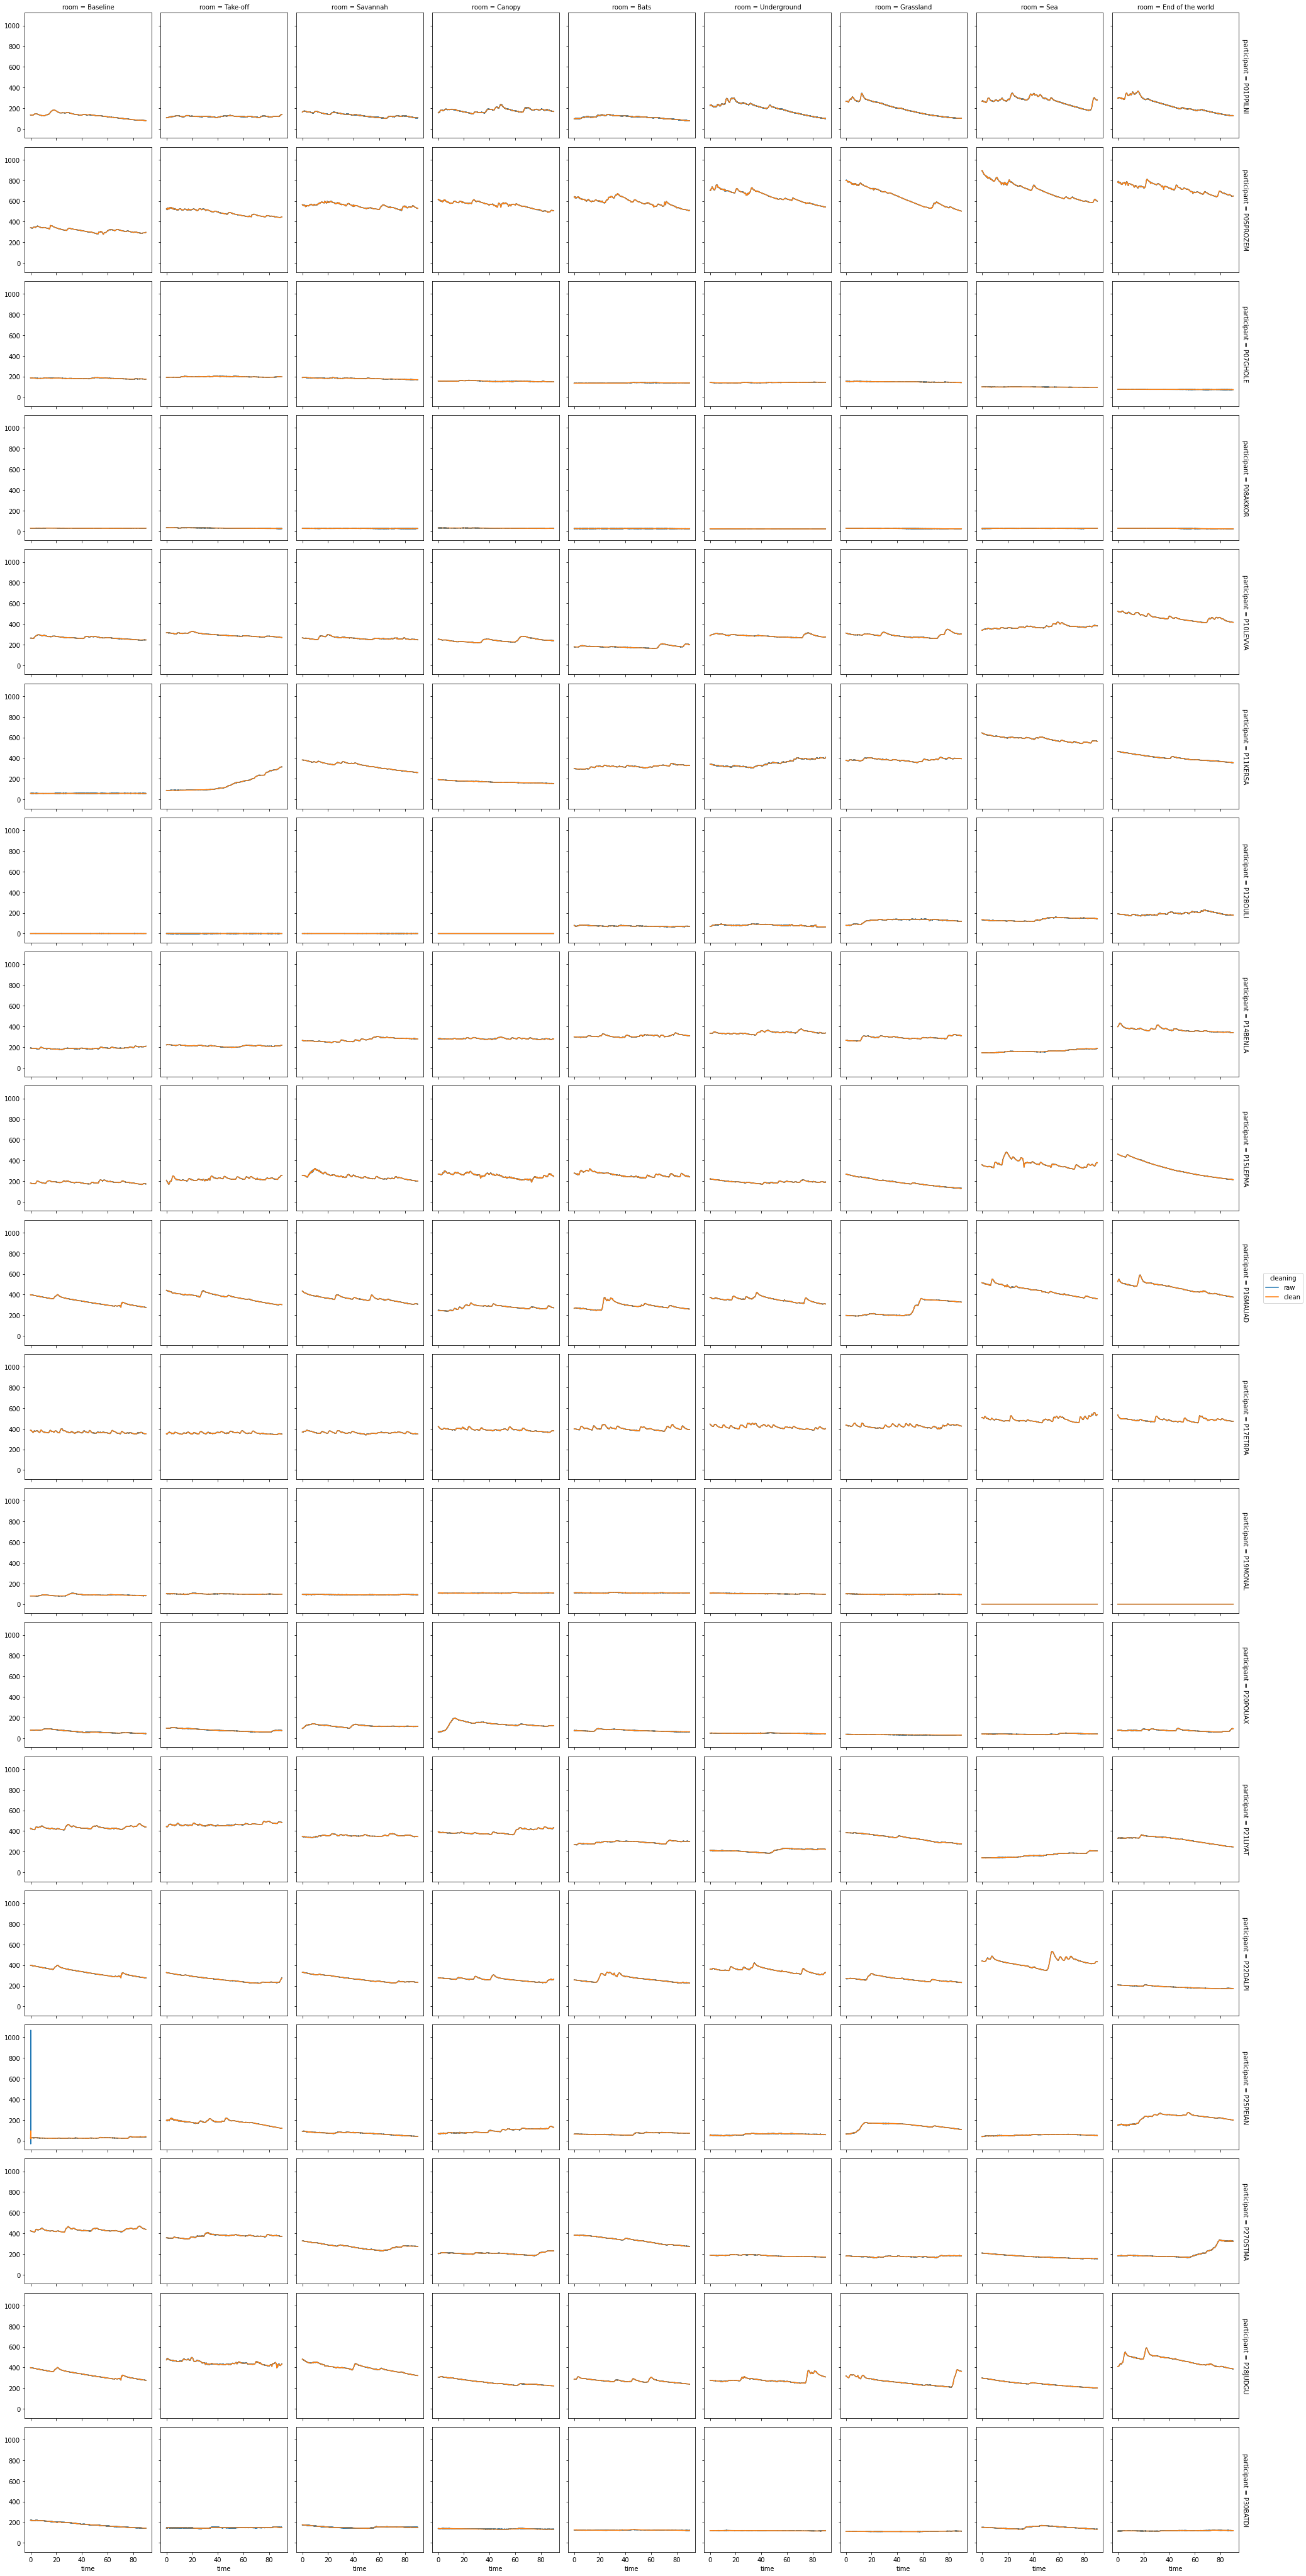

In [10]:
da_cleaned.sel(biosig = 'EDA').plot.line(x='time',row = 'participant',col = 'room', hue = 'cleaning')

EEG


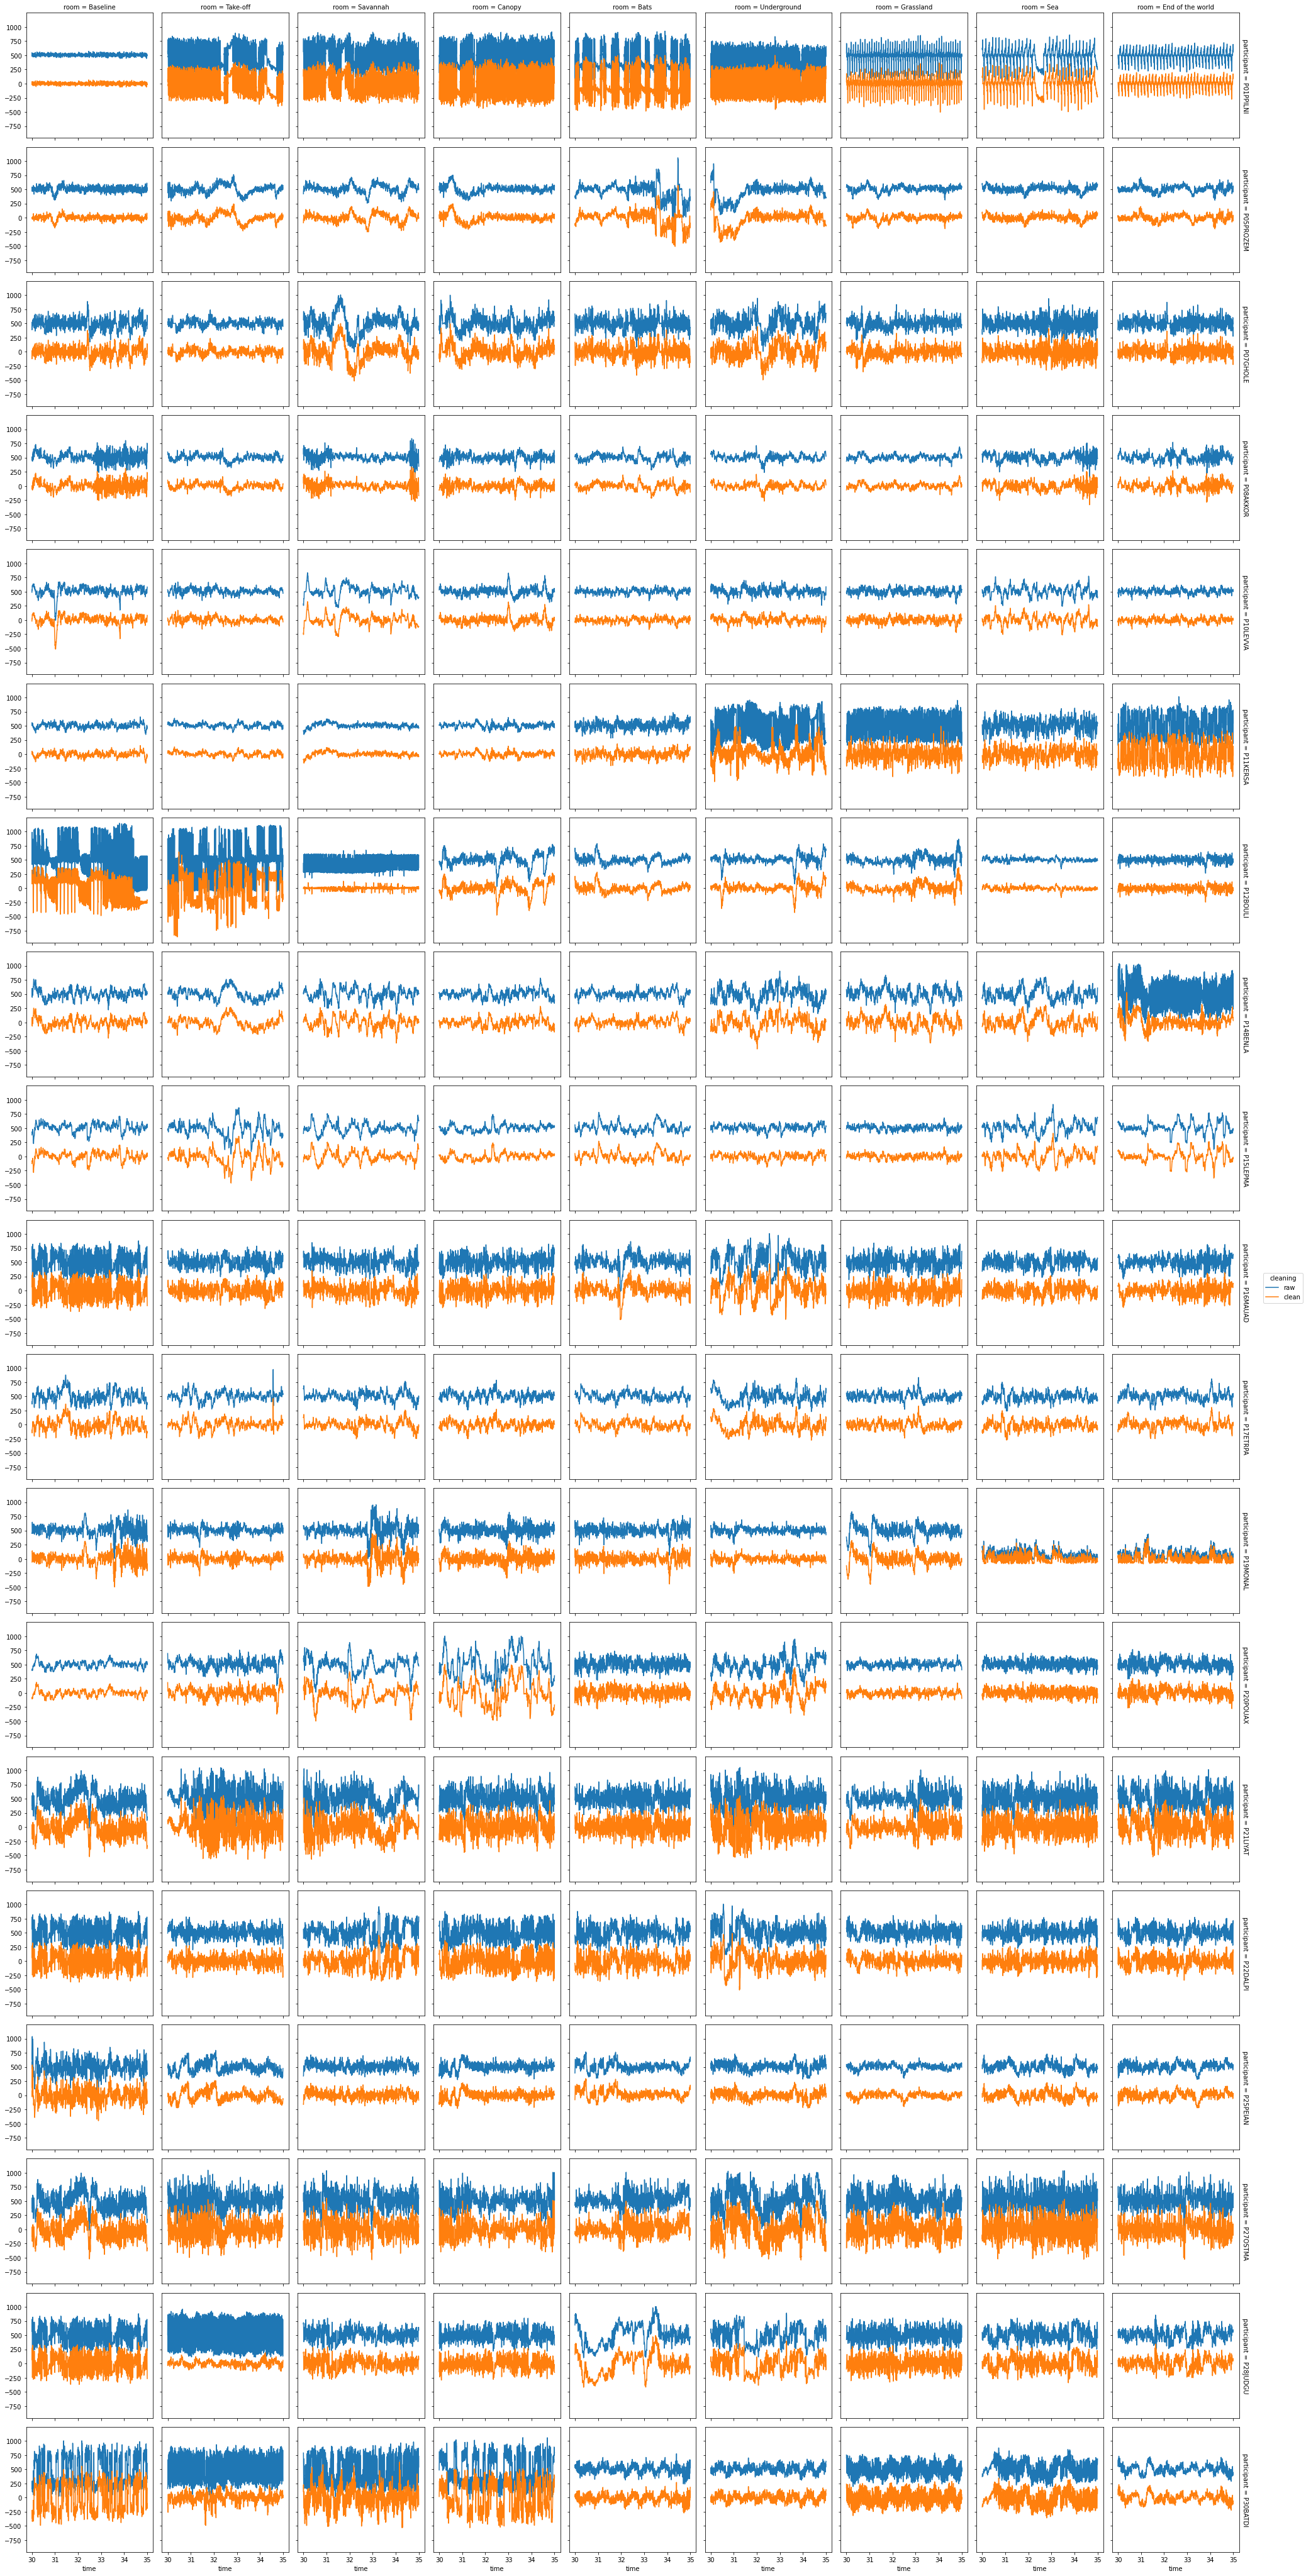

ECG


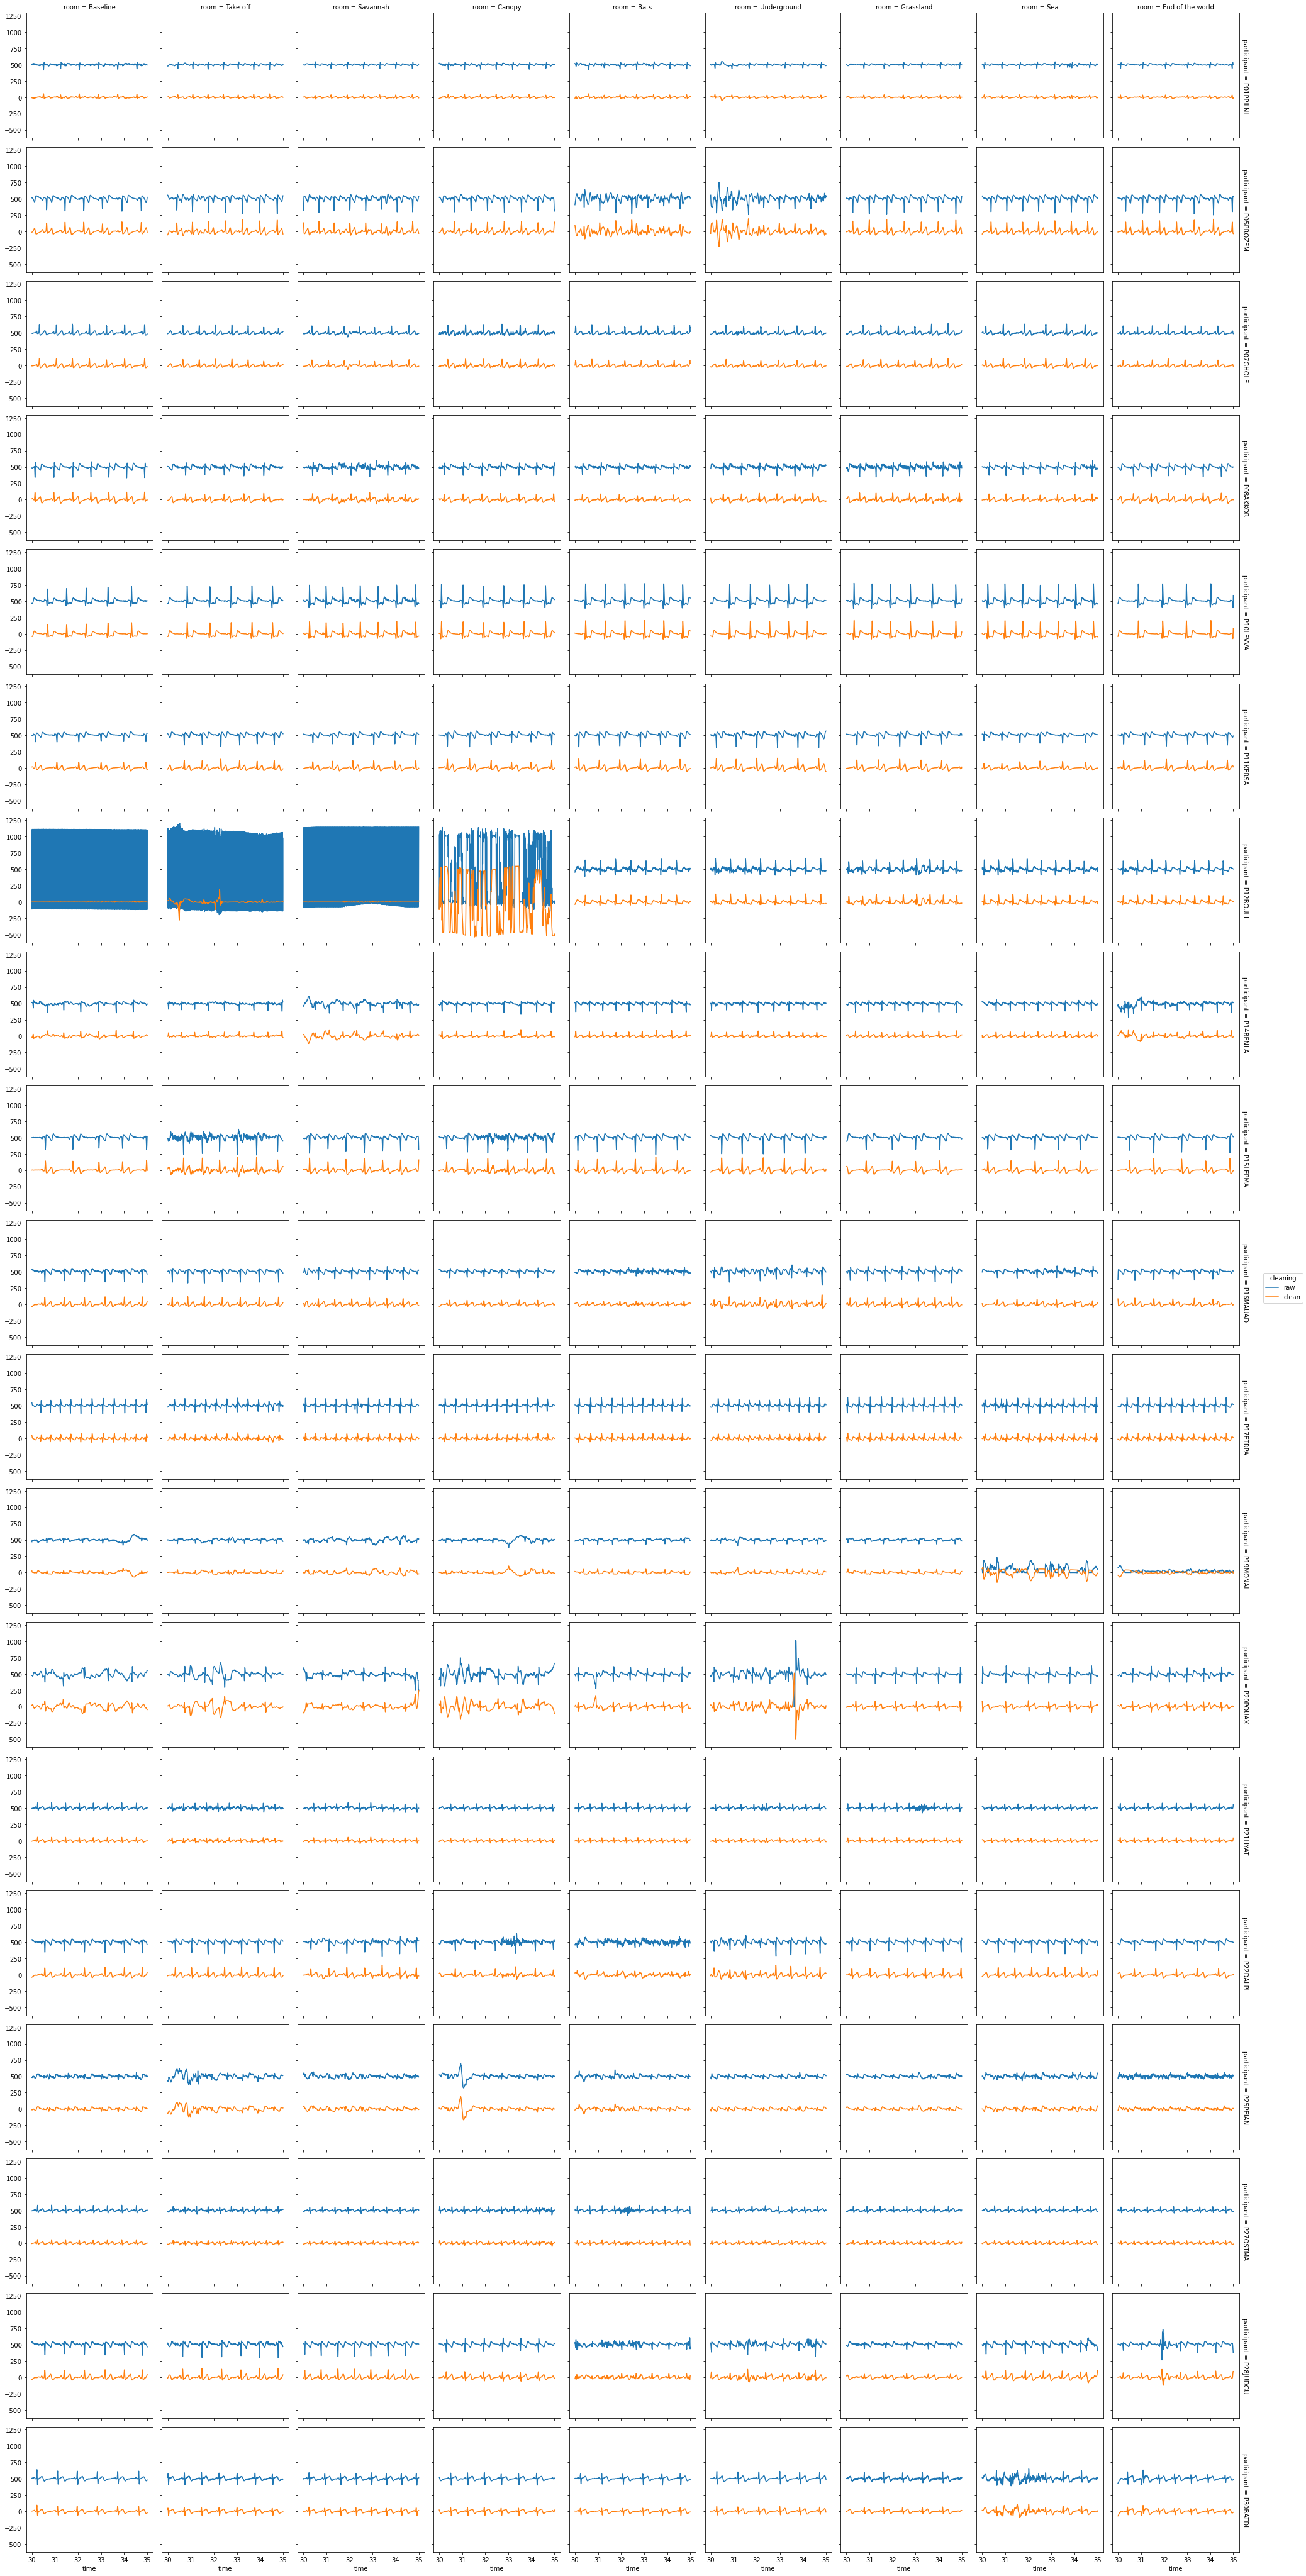

EDA


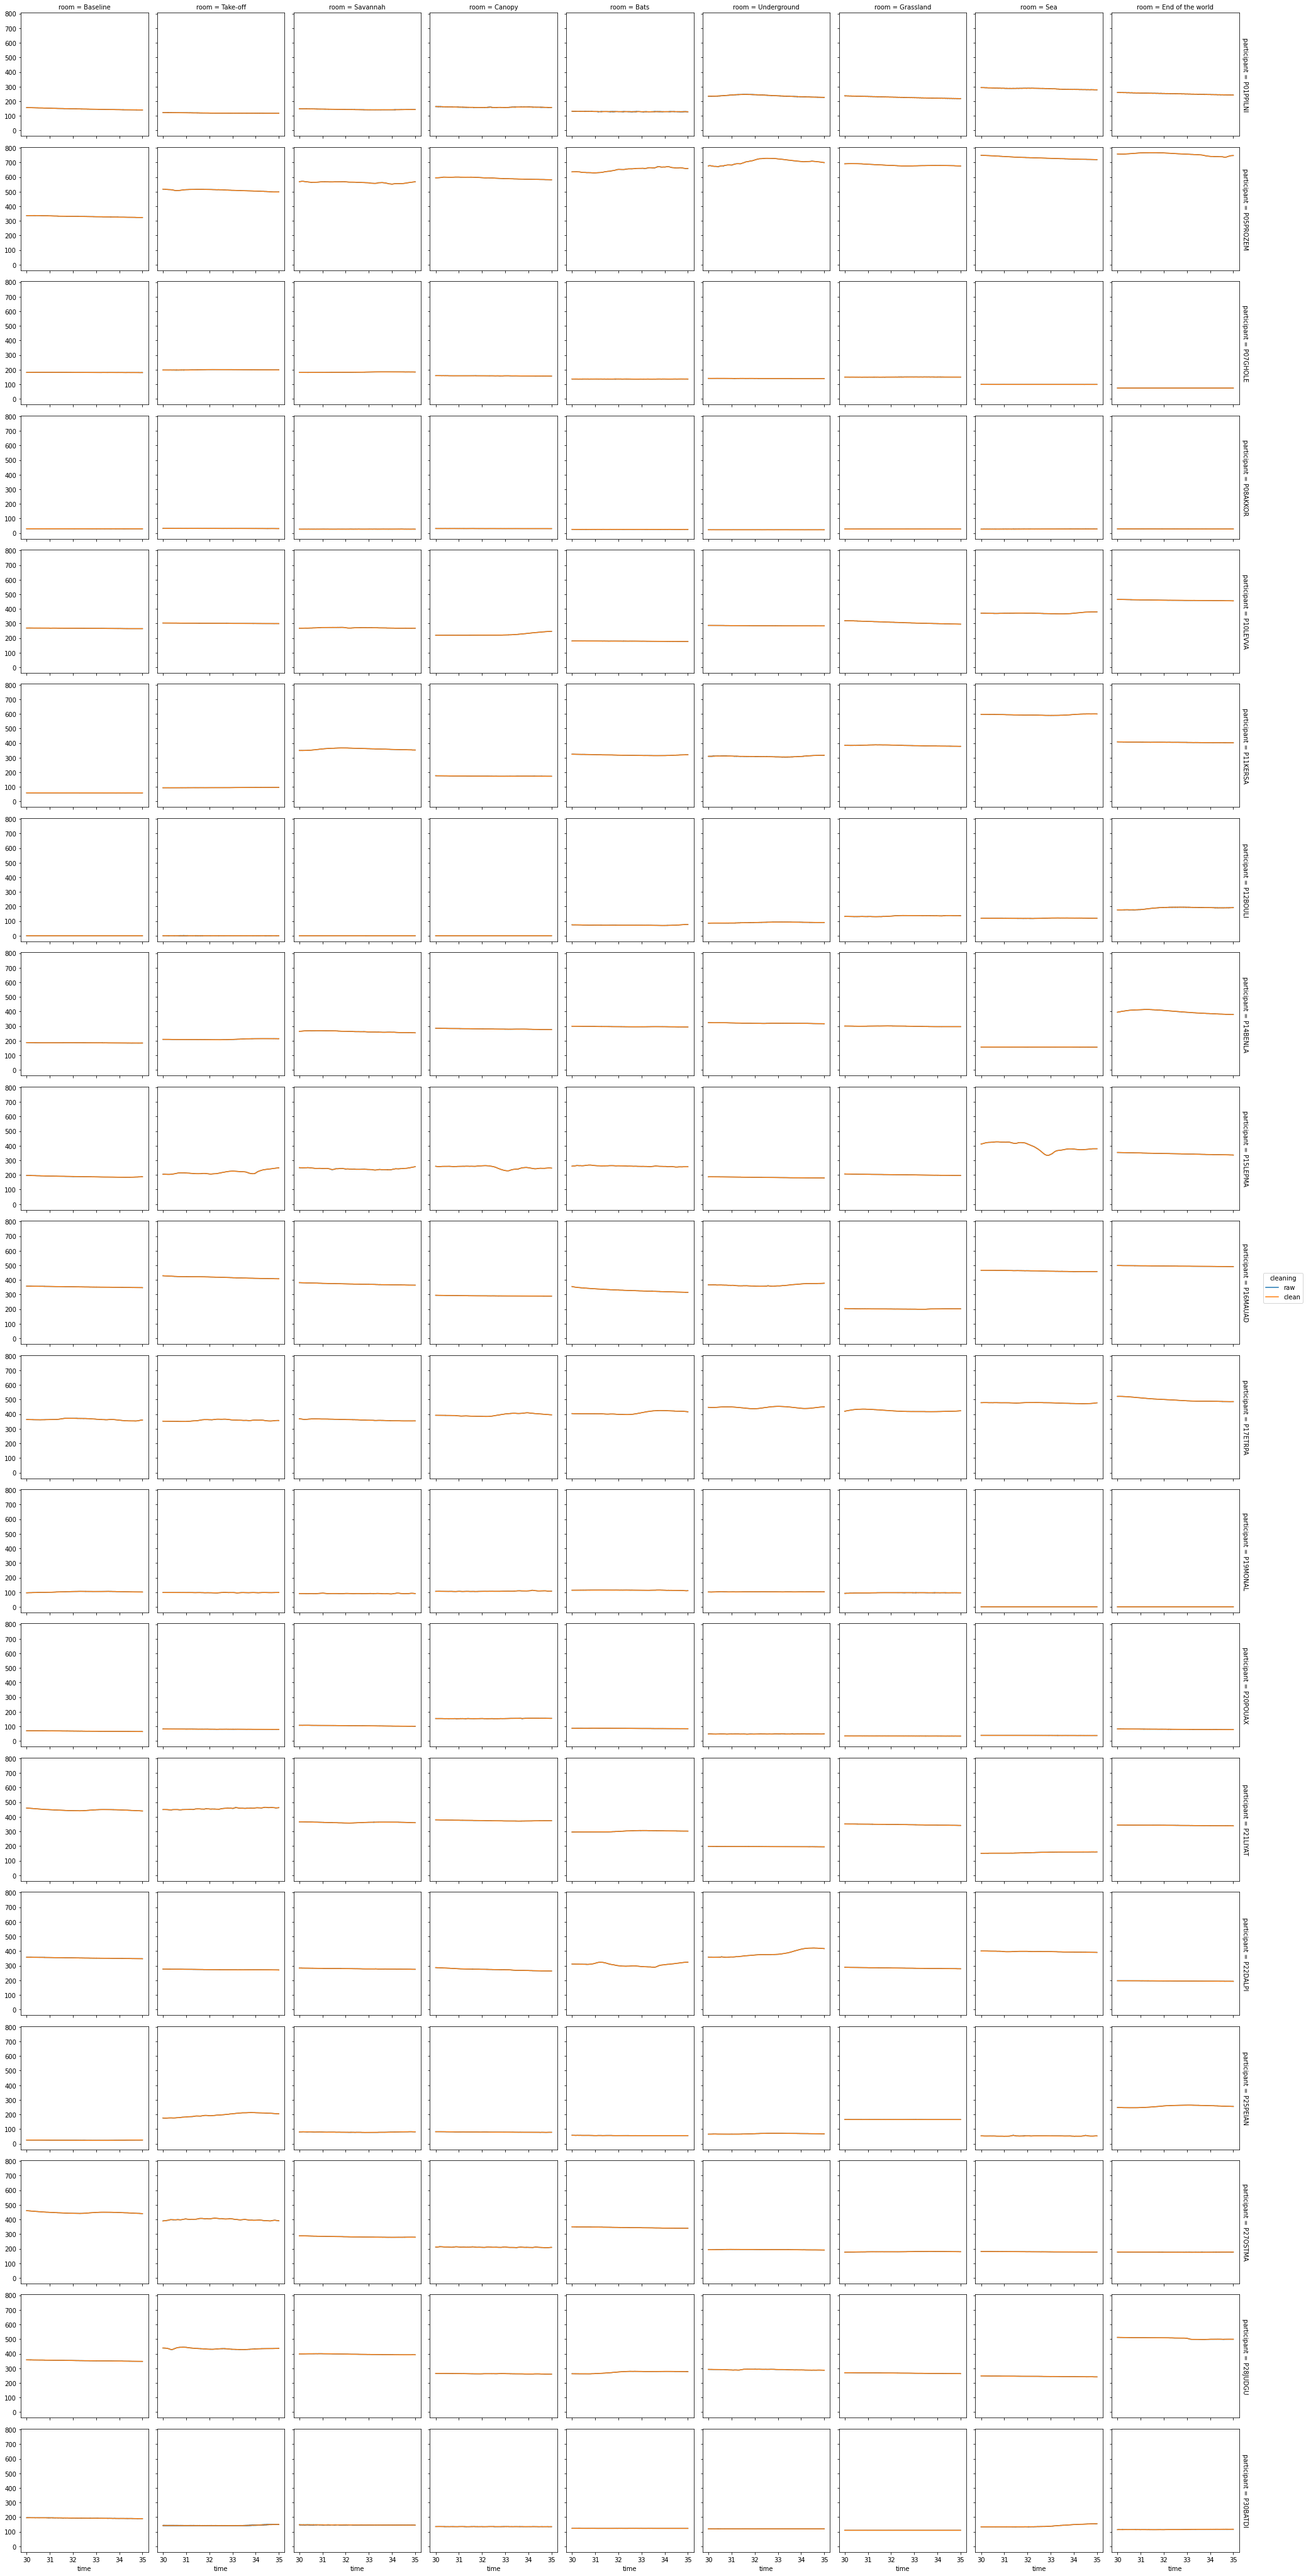

PPG


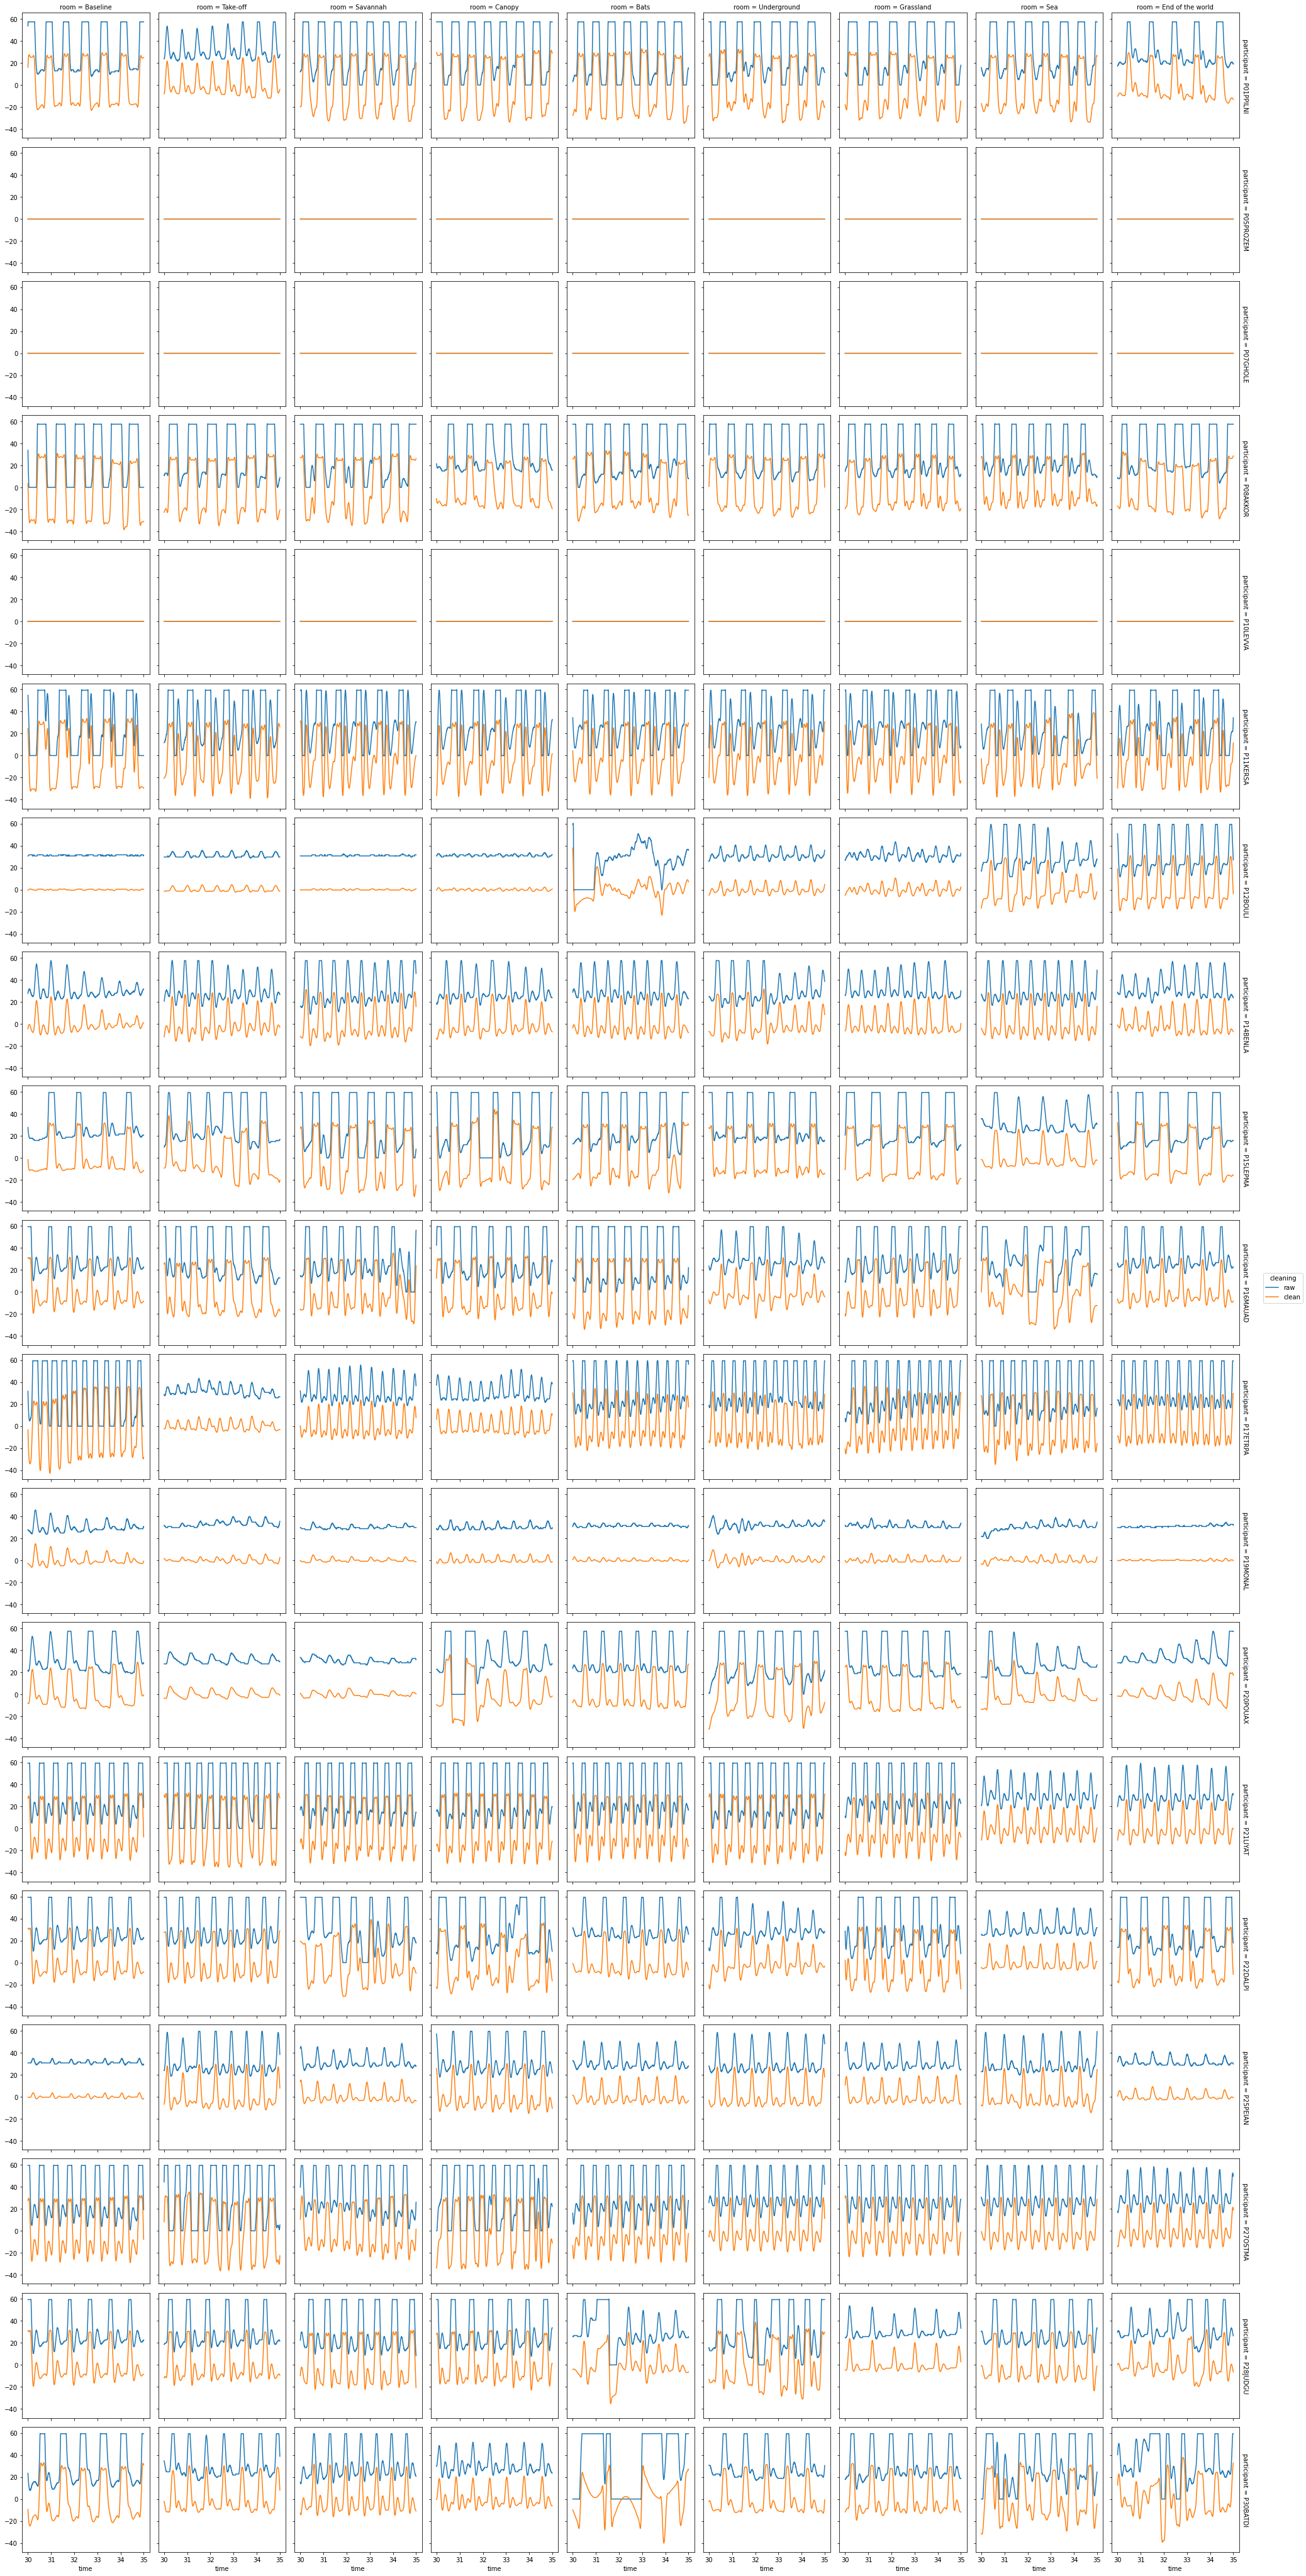

In [11]:
for d in biosigs:
    print(d)
    da_cleaned.sel(biosig = d, time = slice(30,35)).plot.line(x='time',row = 'participant',col = 'room', hue = 'cleaning')
    plt.show()

In [12]:
quality = pd.read_excel('../data_preprocessed/quality_encoding.xlsx', index_col = 0)
quality.groupby('biosig').mean() # score of quality (visual inspection) by biosig, max = 2, min = 0

KeyError: 'biosig'